<a href="https://colab.research.google.com/github/JasonPham808/Image-Based-Recyclable-Material-Classification/blob/main/Huy_Hung_Pham_MIS780A2_Task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIS780 Advanced AI For Business - Assessment 2 - T2 2025

## Task Number: Forecasting Air Quality Pollution (PM2.5 Concentration) with Time-series Data

**Student Name:** _Huy Hung Pham_

**Student ID:** _s224212292_

## Table of Content

1. [Executive Summary](#cell_Summary)

2. [Data Preprocessing](#cell_Preprocessing)

3. [Predictive Modeling](#cell_model)

4. [Experiments Report](#cell_report)

5. [Role of GenAI](#cell_GenAI)



<a id = "cell_Summary"></a>
## 1. Executive Summary

<a id = "cell_Preprocessing"></a>
## 2. Data Preprocessing

#### 2.1. Initialisation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(224212292)
np.random.seed(224212292)

### 2.2 Importing dataset

In [ ]:
dataset = pd.read_csv(
    '/content/drive/MyDrive/MIS780_A2/Task 3 Dataset Air Quality.csv'
    )
print(dataset.tail())

               datetime  PM2.5  SO2   NO2   CO    O3  TEMP    PRES  DEWP  WSPM
35059  28/02/2017 19:00   14.0  3.0  27.0  400  72.0  12.5  1013.5 -16.2   2.4
35060  28/02/2017 20:00   18.0  3.0  37.0  400  59.0  11.6  1013.6 -15.1   0.9
35061  28/02/2017 21:00   15.0  5.0  50.0  600  41.0  10.8  1014.2 -13.3   1.1
35062  28/02/2017 22:00   11.0  6.0  49.0  500  41.0  10.5  1014.4 -12.9   1.2
35063  28/02/2017 23:00   10.0  7.0  48.0  600  39.0   8.6  1014.1 -15.9   1.3


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  35064 non-null  object 
 1   PM2.5     35064 non-null  float64
 2   SO2       35064 non-null  float64
 3   NO2       34372 non-null  float64
 4   CO        35064 non-null  int64  
 5   O3        34558 non-null  float64
 6   TEMP      35064 non-null  float64
 7   PRES      35064 non-null  float64
 8   DEWP      35064 non-null  float64
 9   WSPM      35064 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 2.7+ MB


In [ ]:
print(dataset.describe())

              PM2.5           SO2           NO2            CO            O3  \
count  35064.000000  35064.000000  34372.000000  35064.000000  34558.000000   
mean      84.518994     18.679584     58.097172   1320.073266     58.534682   
std       85.482426     24.125895     36.297740   1223.774709     58.401448   
min        2.000000      0.570000      2.000000    100.000000      0.214200   
25%       23.000000      3.000000     29.000000    500.000000     10.000000   
50%       60.000000      9.000000     51.000000   1000.000000     45.000000   
75%      114.000000     23.000000     80.000000   1600.000000     84.000000   
max      844.000000    257.000000    273.000000  10000.000000    390.000000   

               TEMP          PRES          DEWP          WSPM  
count  35064.000000  35064.000000  35064.000000  35064.000000  
mean      13.672020   1012.547222      2.447850      1.860641  
std       11.455204     10.263134     13.806763      1.280133  
min      -16.800000    987.10000

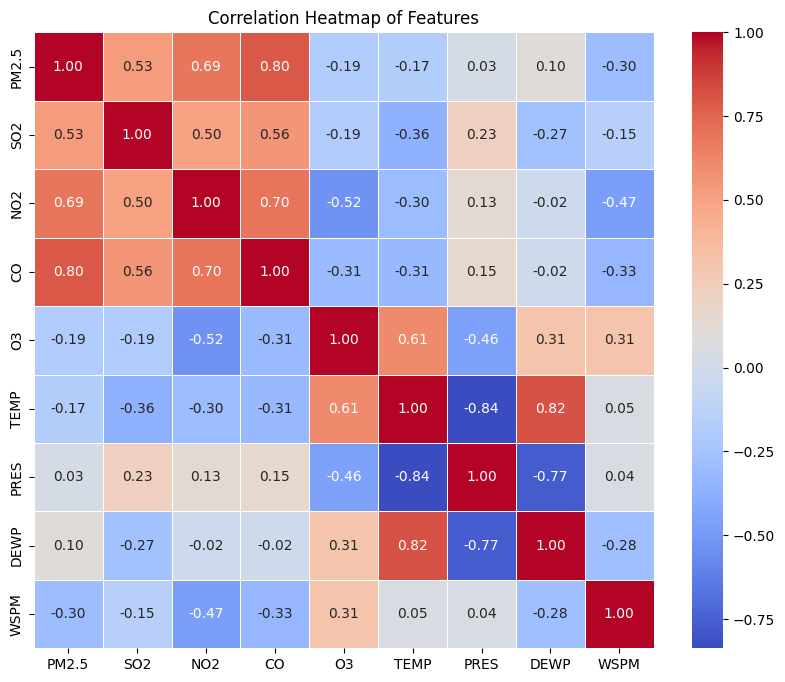

In [ ]:
# Convert 'datetime' column to datetime objects and set as index
dataset['datetime'] = pd.to_datetime(dataset['datetime'], format='%d/%m/%Y %H:%M', errors='coerce')
dataset = dataset.set_index('datetime')

# Calculate the correlation matrix
correlation_matrix = dataset.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Features')
plt.show()

In [ ]:


display(dataset.head())

,PM2.5,SO2,NO2,CO,O3,TEMP,PRES,DEWP,WSPM
datetime,,,,,,,,,
2013-03-01 00:00:00,5.0,4.0,12.0,200,85.0,-0.5,1024.5,-21.4,5.7
2013-03-01 01:00:00,8.0,6.0,14.0,200,84.0,-0.7,1025.1,-22.1,3.9
2013-03-01 02:00:00,3.0,5.0,14.0,200,83.0,-1.2,1025.3,-24.6,5.3
2013-03-01 03:00:00,5.0,5.0,14.0,200,84.0,-1.4,1026.2,-25.5,4.9
2013-03-01 04:00:00,5.0,6.0,21.0,200,77.0,-1.9,1027.1,-24.5,3.2


The decision to exclude the columns 'O3', 'TEMP', 'PRES', 'DEWP', and 'WSPM' is informed by the analysis of the correlation heatmap, which indicates weak correlations between these features and 'PM2.5'—specifically, O3 (-0.19), TEMP (-0.17), PRES (0.03), DEWP (0.10), and WSPM (-0.30). In contrast, stronger correlations have been observed with 'SO2' (0.53), 'NO2' (0.68), and 'CO' (0.80). Features exhibiting weak correlations are less impactful in predictive modeling; therefore, their exclusion can streamline the model, diminish noise, and enhance overall performance by concentrating on the more pertinent features.

### 2.3 Determine missing values

In [ ]:
dataset.isna().sum()

,0
PM2.5,0
SO2,0
NO2,692
CO,0
O3,506
TEMP,0
PRES,0
DEWP,0
WSPM,0


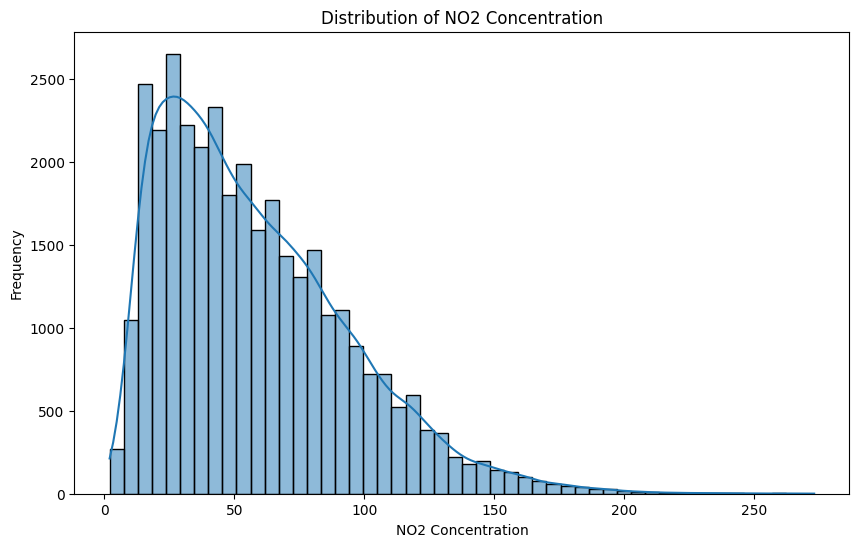

In [ ]:
# Create a histogram for the 'NO2' column to visualize its distribution
plt.figure(figsize=(10, 6))
sns.histplot(dataset['NO2'], kde=True, bins=50)
plt.title('Distribution of NO2 Concentration')
plt.xlabel('NO2 Concentration')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Handle missing values in the 'NO2' column by filling with the mean
dataset['NO2'] = dataset['NO2'].fillna(dataset['NO2'].mean())
dataset['O3'] = dataset['O3'].fillna(dataset['O3'].mean())

# Verify that there are no more missing values in the relevant columns
print(dataset[[ 'NO2', 'O3']].isna().sum())

NO2    0
O3     0
dtype: int64


The 'NO2' concentration distribution is slightly right skewed and unimodal. Using the mean to handle missing values is preferable because:

1. **Data Loss**: Removing rows with missing values results in losing 692 data points, reducing the dataset significantly.
   
2. **Bias**: If the missing data isn't random, deletion can introduce bias, especially if lower values are missing. Mean imputation is less likely to skew the results.

3. **Temporal Integrity**: In time series analysis, row deletion can disrupt sequences, while imputation maintains them.

Overall, mean imputation is a reasonable strategy given the low percentage of missing data (2%), helping preserve valuable information.

### 2.5 Simple line graph for multiple time series.

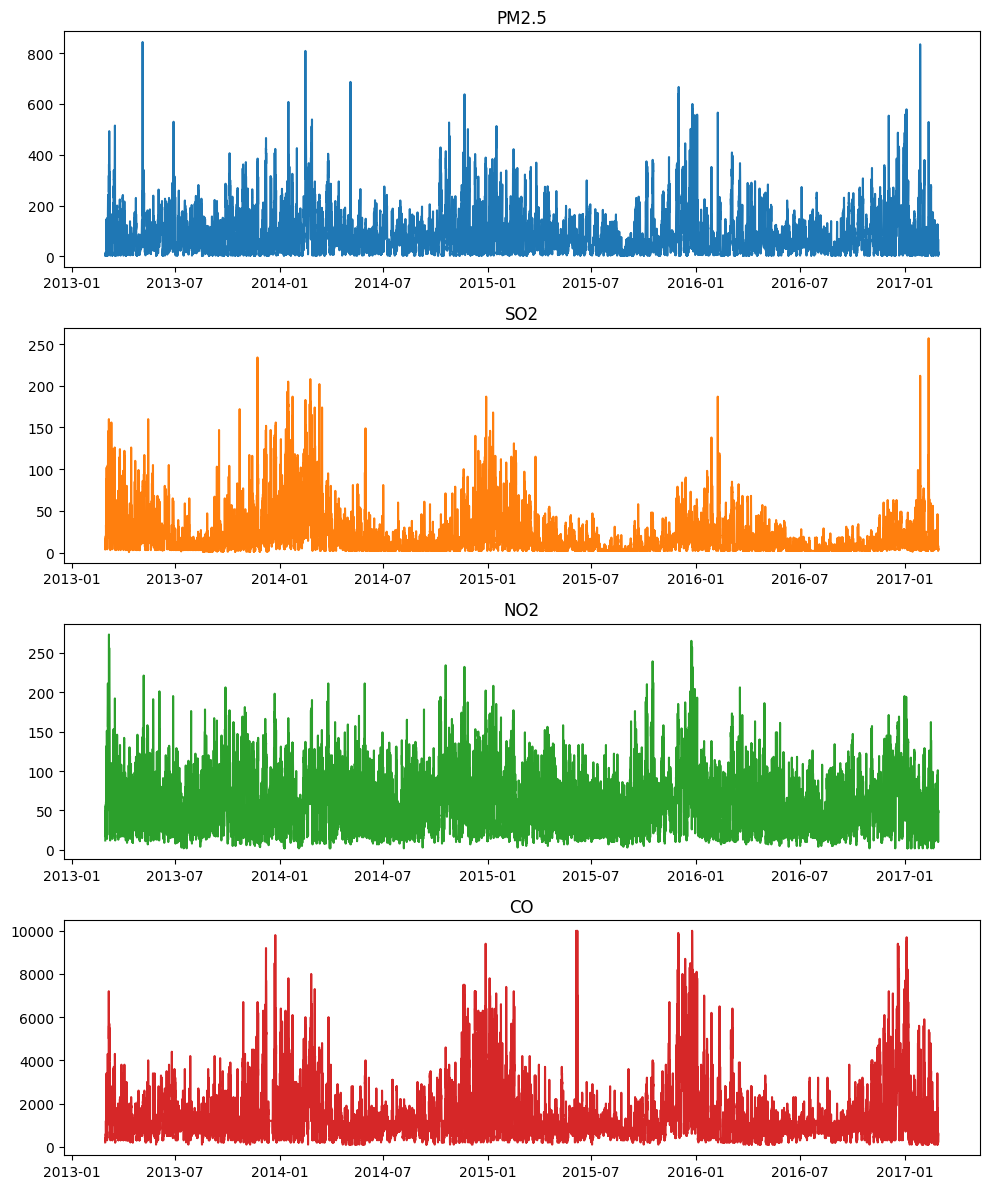

In [ ]:
fig, axs = plt.subplots(4, 1,figsize=(10, 12))
axs[0].plot(dataset['PM2.5'],color='tab:blue')
axs[0].set_title('PM2.5')
axs[1].plot(dataset['SO2'],color='tab:orange')
axs[1].set_title('SO2')
axs[2].plot(dataset['NO2'],color='tab:green')
axs[2].set_title('NO2')
axs[3].plot(dataset['CO'],color='tab:red')
axs[3].set_title('CO')
plt.tight_layout()

### 2.6 Splitting dataset

In [ ]:
# Function to split the dataset into training and test sets based on a specified year
def train_test_split(dataset, split_year):
    # Data before the split_year for training
    train = dataset.loc[dataset.index.year < split_year]
    # Data from the split_year onwards for testing
    test = dataset.loc[dataset.index.year >= split_year]
    return train, test

 In this section, the  'datetime' column is converted to proper datetime objects and set as the DataFrame's index. This is essential for the *train_test_split* function, which requires a DatetimeIndex to extract the year.

In [ ]:

# Split the dataset using 2016 as the split year
training_set, test_set = train_test_split(dataset, 2016)
training_set_shape = training_set.shape
test_set_shape = test_set.shape
print('training_set shape:', training_set_shape)
print('test_set shape:', test_set_shape)

training_set shape: (24864, 10)
test_set shape: (10200, 10)


The function produces two DataFrames: one designated for the training set and another for the test set, which are subsequently assigned to the variables training_set and test_set, respectively. According to the logic of the train_test_split function and the previously implemented modification, the training_set will encompass data prior to the year 2016, while the test_set will consist of data from 2016 onward.

### 2.7 Scalling the dataset

In [ ]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
print('training_set_scaled shape after scaling:', training_set_scaled.shape)

training_set_scaled shape after scaling: (24864, 10)


This section of the code prepares the training data through a process known as "scaling," which adjusts numerical values to a consistent range of 0 to 1. This is crucial because certain measurements, such as carbon monoxide (CO), may have significantly larger values than others, like particulate matter (PM2.5). Scaling ensures that the model learns effectively from all measurements by preventing any single value from dominating. The code first determines the appropriate scaling parameters from the training data and then applies these parameters to scale the dataset.

Transform back to table format with four features.

In [ ]:
training_set_scaled = training_set_scaled.reshape(training_set_shape[0], training_set_shape[1])
print('training_set_scaled shape:', training_set_scaled.shape)

training_set_scaled shape: (24864, 10)


Transform back to table format

In [ ]:
def split_sequence(sequence, n_steps,forecasting_horizon, y_index):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - forecasting_horizon:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:end_ix+forecasting_horizon,y_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
n_steps = 72
forecasting_horizon = 24
features = 10 # Corrected from 4 to 10
y_index = 1 # the index of PM2.5
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps,forecasting_horizon,y_index)

The forecasting horizon is set to 24 hours, indicating a prediction for the next day. The model looks back at the previous 72 hours of data (n_steps) for its forecasts.

Nine features are used as input: 'PM2.5', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', and 'WSPM.' The split_sequence function creates pairs of input sequences (X_train) and output sequences (y_train) for the LSTM model to learn from, focusing on the target variable 'PM2.5.'

Reshaping the  ensure that the shape of X_train and y_train are compartible with the RNN model.

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 10)

In [ ]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_train shape: (24769, 72, 10)
y_train shape: (24769, 24)


In [ ]:
plt.figure(figsize=(7, ))
plt.plot(np.arange(1, n_steps+1, 1),X_train[0,:,0])
plt.plot(np.arange(1, n_steps+1, 1),X_train[0,:,1])
plt.plot(np.arange(1, n_steps+1, 1),X_train[0,:,2])
plt.plot(np.arange(1, n_steps+1, 1),X_train[0,:,3])
plt.plot(np.arange(n_steps, n_steps+forecasting_horizon, 1),y_train[0])
plt.title('One Training Sample')
plt.ylabel('Measurement')
plt.xlabel('Time')
plt.legend(['PM2.5', 'SO2', 'NO2', 'CO', 'y_train'], loc='upper right')

TypeError: Bbox.from_bounds() missing 1 required positional argument: 'height'

This time series chart illustrates air quality indicators and a training target over time for a single sample, featuring five variables:

- **PM2.5 (blue):** Fine particulate matter
- **SO2 (orange):** Sulfur dioxide
- **NO2 (green):** Nitrogen dioxide
- **CO (red):** Carbon monoxide
- **y_train (purple):** Training target variable

The pollutants display varying concentrations with notable peaks and troughs, suggesting correlations; for example, around time step 60, all features decline sharply and then rebound, indicating a common event. The purple line (y_train) starts after time 65, representing a forecast target informed by past pollutant values.

<a id = "cell_model"></a>
## 3. Predictive Modeling

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], features)))
model_lstm.add(LSTM(units=128, return_sequences=False))
model_lstm.add(Dense(units=forecasting_horizon))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

model_lstm.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 72, 64)         │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,112 (473.09 KB)

 Trainable params: 121,112 (473.09 KB)

 Non-trainable params: 0 (0.00 B)

The stacked LSTM architecture with two layers. The first LSTM layer, containing 64 units and configured with return_sequences=True, outputs a full sequence of hidden states for temporal processing. The second layer has 128 units and outputs only the last hidden state (return_sequences=False), summarizing the processed sequence into a fixed-size feature vector. To combat overfitting, dropout layers with a rate of 0.2 are applied after each LSTM layer.

At the end, a Dense output layer generates continuous predictions using a linear activation function. The model is compiled with the Adam optimizer and optimized using mean squared error, making it suitable for regression tasks like time series forecasting. This architecture effectively learns complex temporal dependencies while balancing depth and regularization

In [ ]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=64)

Epoch 1/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0081
Epoch 2/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0067
Epoch 3/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0063
Epoch 4/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0059
Epoch 5/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0056
Epoch 6/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0055
Epoch 7/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0052
Epoch 8/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0048
Epoch 9/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0043
Epoch 10/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0040
Epoch 11/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0035
Epoch 12/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0032
Epoch 13/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0030
Epoch 14/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0027
Epoch 15/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - lo

The model will train on 100 epochs with 64 batch sizes. The epochs parameter specifies the number of times the model will iterate over the entire training dataset, and the batch_size parameter specifies the number of samples that will be used in each iteration.

## 4. RNN Testing

### 4.1 Scalling

In [ ]:
# Apply the scaler
inputs = test_set.values
inputs = sc.transform(inputs)
inputs = inputs.reshape(test_set_shape[0], test_set_shape[1])
# Split into samples
X_test, y_test = split_sequence(inputs, n_steps,forecasting_horizon,y_index)
number_test_samples = X_test.shape[0]
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_test shape: (10105, 72, 10)
y_test shape: (10105, 24)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


### 4.2 Fit target scaler just to the training target values

In [ ]:
from sklearn.preprocessing import MinMaxScaler
target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))
# When predicting
predicted_pm25 = model_lstm.predict(X_test)
#Inverse transform predictions
predicted_pm25 = target_scaler.inverse_transform(predicted_pm25)


316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


### 4.3 Evaluate the prediction performance between the true and predicted values

In [ ]:
def return_mae(test, predicted):
    mae = mean_absolute_error(test, predicted)
    print("Mean Absolute Error {:.2f}.".format(mae))

for i in range(forecasting_horizon):
  print("Forecasting Horizon: {} ".format(i))
  return_mae(y_test[:,i],predicted_pm25[:,i])
  print("")

Forecasting Horizon: 0 
Mean Absolute Error 0.02.

Forecasting Horizon: 1 
Mean Absolute Error 0.03.

Forecasting Horizon: 2 
Mean Absolute Error 0.03.

Forecasting Horizon: 3 
Mean Absolute Error 0.03.

Forecasting Horizon: 4 
Mean Absolute Error 0.04.

Forecasting Horizon: 5 
Mean Absolute Error 0.04.

Forecasting Horizon: 6 
Mean Absolute Error 0.04.

Forecasting Horizon: 7 
Mean Absolute Error 0.04.

Forecasting Horizon: 8 
Mean Absolute Error 0.04.

Forecasting Horizon: 9 
Mean Absolute Error 0.04.

Forecasting Horizon: 10 
Mean Absolute Error 0.04.

Forecasting Horizon: 11 
Mean Absolute Error 0.04.

Forecasting Horizon: 12 
Mean Absolute Error 0.04.

Forecasting Horizon: 13 
Mean Absolute Error 0.04.

Forecasting Horizon: 14 
Mean Absolute Error 0.05.

Forecasting Horizon: 15 
Mean Absolute Error 0.05.

Forecasting Horizon: 16 
Mean Absolute Error 0.05.

Forecasting Horizon: 17 
Mean Absolute Error 0.05.

Forecasting Horizon: 18 
Mean Absolute Error 0.05.

Forecasting Horizon: 1

Calculate MAE for each forecasting horizon

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error

# Assuming y_test and predicted_stock_price are already defined and have the same shape (samples, forecasting_horizon)


mae_per_horizon = [mean_absolute_error(y_test[:, i], predicted_pm25[:, i]) for i in range(forecasting_horizon)]

# Calculate the average MAE across all forecasting horizons
average_mae = np.mean(mae_per_horizon)

print(f"Average Mean Absolute Error (MAE) across all forecasting horizons: {average_mae:.2f}")

Average Mean Absolute Error (MAE) across all forecasting horizons: 0.04


### 4.4 visualize the real vs. predicted values

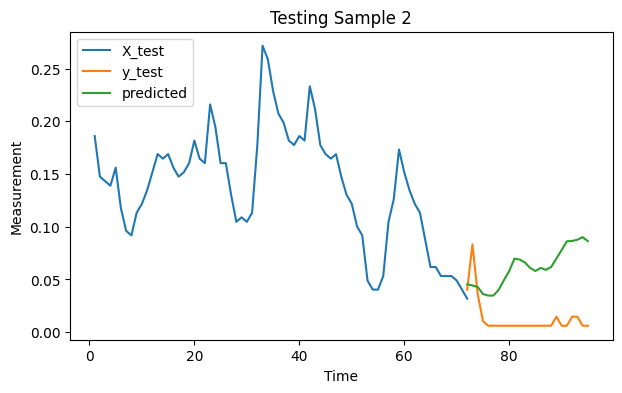

In [ ]:
#Here we visualize the real vs. predicted values of the last testing segment.
sample_index = 2

plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, n_steps+1, 1),X_test[sample_index,:,1])
plt.plot(np.arange(n_steps, n_steps+forecasting_horizon, 1),y_test[sample_index,:])
plt.plot(np.arange(n_steps, n_steps+forecasting_horizon, 1),predicted_pm25[sample_index,:])
plt.title('Testing Sample ' + str(sample_index))
plt.ylabel('Measurement')
plt.xlabel('Time')
plt.legend(['X_test', 'y_test', 'predicted'], loc='upper left')

The historical SO2 data (blue line) shows fluctuations, including a dip around time steps 60 to 70. The true PM2.5 values (orange line) experience a sharp decline at the beginning of the forecasting horizon and then remain stable. In contrast, the predicted PM2.5 values (green line) start higher than the true values and show a gradual decline, failing to capture the initial sharp drop in pollution. As a result, the predicted values remain consistently higher than the actual values. Overall, the model's predictions do not align well with the true PM2.5 trend for this sample, particularly missing the sudden decrease in pollution.

Visualize the testing and predicted values of each testing time series segment.

In [ ]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("PM2.5 Prediction")
    plt.xlabel("Hours Ahead")
    plt.ylabel("PM2.5 Concentration")
    plt.legend()
    plt.show()

Visualize all the real testing values versus the all predicted values based on each forecasting horizon.

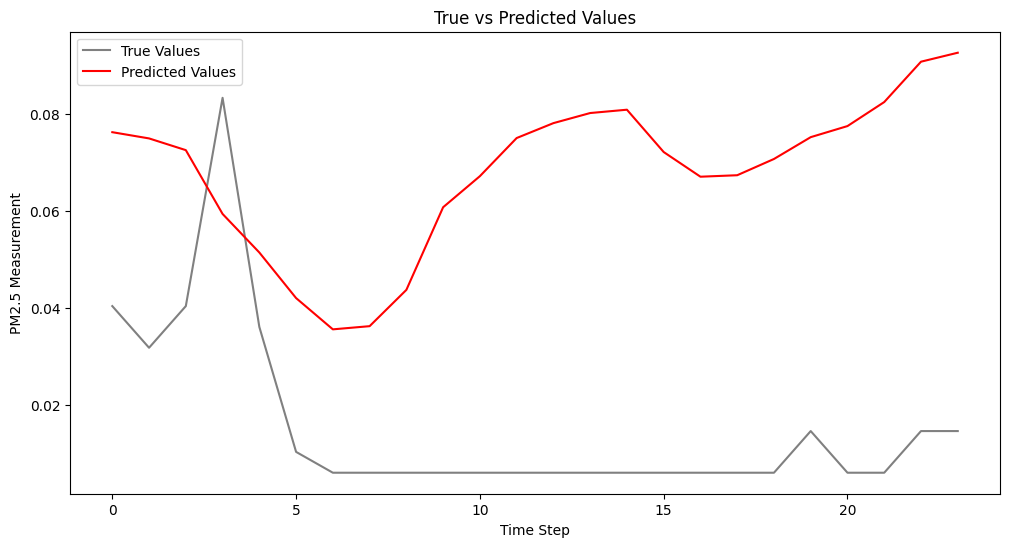

In [ ]:
def plot_predictions(test, predicted):
    plt.figure(figsize=(12, 6))
    plt.plot(test, color="gray", label="True Values")
    plt.plot(predicted, color="red", label="Predicted Values")
    plt.title('True vs Predicted Values')
    plt.xlabel('Time Step')
    plt.ylabel('PM2.5 Measurement')
    plt.legend()
    plt.show()
#Here we visualize the real vs. predicted values for one day forecasting horizon.
plot_predictions(y_test[0,:],predicted_pm25[0,:])

The graph presents a comparative analysis of the actual PM2.5 measurements, represented by the gray line, against the predicted values indicated by the red line across the forecast horizon. Initially, the true measurements exhibit a peak at time step three, followed by a swift decline to nearly zero for the remainder of the timeline. Conversely, the predicted values retain a relatively stable and elevated level throughout the observed period, failing to reflect the significant downturn evident in the true data. This observation implies that while the model is capable of inferring the overall trend and range of magnitudes, it encounters difficulties in accurately depicting abrupt changes or near-zero values, resulting in an overestimation in the later periods.

<a id = "cell_report"></a>
## 4. Experiments Report

*Provide a summary of experimental results, explain the meaning of your result
and how your model can be used to address the related business problem.*

<a id = "cell_report"></a>
## 5. Role of GenAI
